In [100]:
import warnings
warnings.filterwarnings("ignore")

In [101]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, mutual_info_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture as GMM
from sklearn.svm import OneClassSVM

dataset_column_names = ["gas"]
basic_features = ["DR_%s",
                  "|DR|_%s",
                  "EMAi0.001_%s",
                  "EMAi0.01_%s",
                  "EMAi0.1_%s",
                  "EMAd0.001_%s",
                  "EMAd0.01_%s",
                  "EMAd0.1_%s"]
full_basic_features = []
for i in range(1, 17):
    for f in basic_features:
        full_basic_features.append(f % i)

features = dataset_column_names + full_basic_features   

In [102]:
batches = []

for batch_num, f in enumerate(os.listdir("driftdataset")):
    batch = pd.read_csv(os.path.join("driftdataset", f),
                        sep=" ",
                        header=None,
                        usecols=range(0, 129))
    batch.columns = features
    batch[["gas", "concentration level"]] = batch["gas"].str.split(';',expand=True)
    batch["batch"] = batch_num + 1
    
    for col in batch.columns:
        if "_" in col:
            batch[col] = batch[col].apply(lambda x: float(x.split(":")[1]))
    
    batches.append(batch)

In [103]:
data_df = pd.concat(batches).reset_index(drop=True)

only_features_df = data_df.drop(["gas", "concentration level", "batch"], axis=1)
normalized_features_df = (only_features_df-only_features_df.mean())/only_features_df.std()

external_vars_df = data_df[["gas", "concentration level"]]

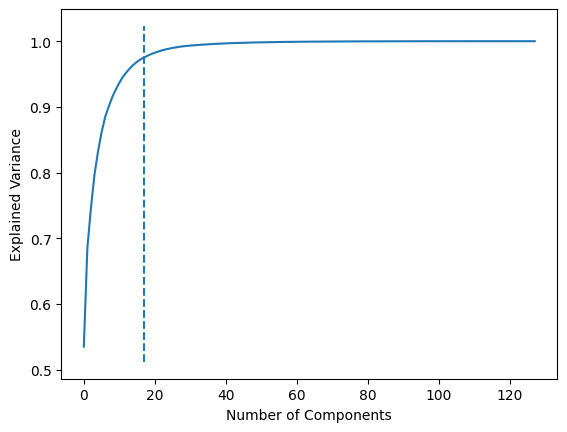

Optimal number of components - 17


In [104]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from kneed import KneeLocator

pca = PCA().fit(normalized_features_df)
ex_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(ex_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

kn = KneeLocator(range(1, len(ex_var_ratio) + 1),
                 ex_var_ratio,
                 direction='increasing')

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.show()

print("Optimal number of components - %s" % kn.knee)

In [105]:
df_pca = PCA(n_components=kn.knee).fit_transform(normalized_features_df)
df_pca = pd.DataFrame(df_pca)

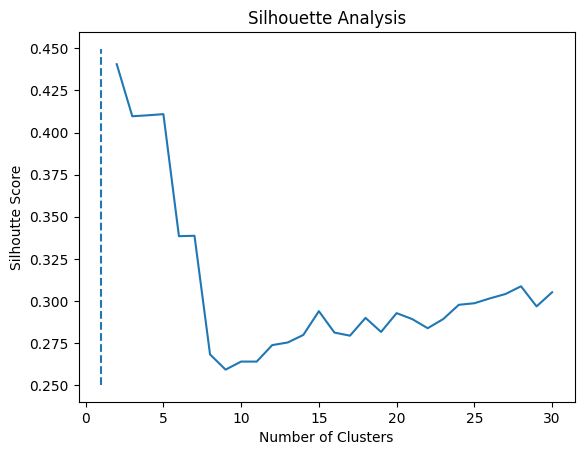

In [106]:
# silhouette analysis
s_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    s_scores.append(silhouette_score(df_pca, kmeans.labels_))

plt.plot(range(2, 31), s_scores)

kn = KneeLocator(range(1, len(s_scores) + 1),
                 s_scores,
                 direction='increasing')

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.title('Silhouette Analysis')
plt.show()

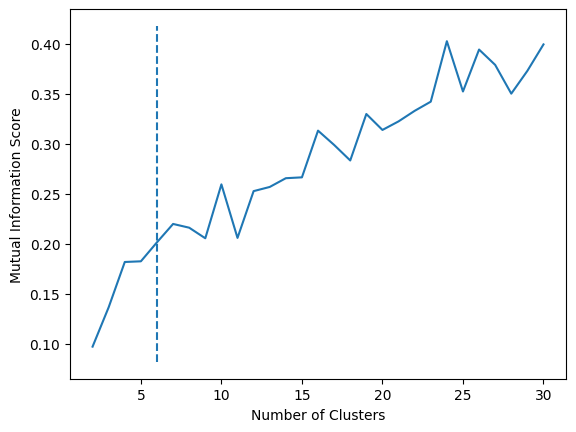

In [107]:
# mutual information analysis
s_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    s_scores.append(adjusted_mutual_info_score(external_vars_df["gas"], kmeans.labels_))

plt.plot(range(2, 31), s_scores)

kn = KneeLocator(range(1, len(s_scores) + 1),
                 s_scores,
                 direction='increasing')

plt.vlines(6, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    
plt.xlabel("Number of Clusters")
plt.ylabel("Mutual Information Score")
plt.show()

**We chose 6 clusters**

In [108]:
kmeans = KMeans(n_clusters=6).fit(df_pca)
dbscan = DBSCAN().fit(df_pca)
gmm = GMM(n_components=6).fit(df_pca)
models = [kmeans, dbscan, gmm]
model_labels = [kmeans.labels_, dbscan.labels_, gmm.predict(df_pca)]

In [109]:
mi_genre_kmeans = mutual_info_score(external_vars_df["gas"], model_labels[0])
mi_genre_dbscan = mutual_info_score(external_vars_df["gas"], model_labels[1])
mi_genre_gmm = mutual_info_score(external_vars_df["gas"], model_labels[2])

sil_genre_kmeans = silhouette_score(df_pca, model_labels[0])
sil_genre_dbscan = silhouette_score(df_pca, model_labels[1])
sil_genre_gmm = silhouette_score(df_pca, model_labels[2])

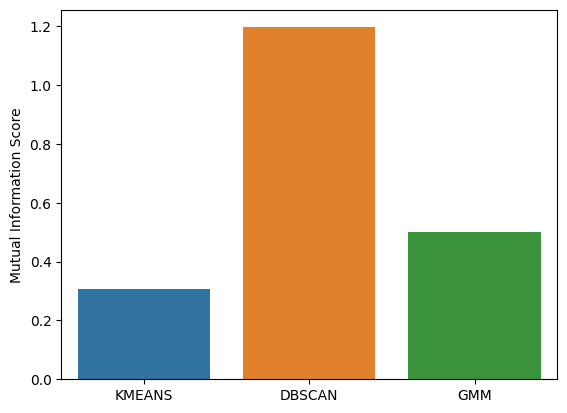

In [110]:
sns.barplot(x=["KMEANS", "DBSCAN", "GMM"], y=[mi_genre_kmeans, mi_genre_dbscan, mi_genre_gmm])
plt.ylabel("Mutual Information Score")
plt.show()

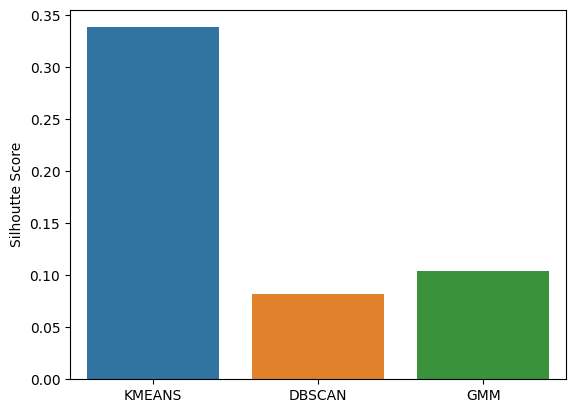

In [111]:
sns.barplot(x=["KMEANS", "DBSCAN", "GMM"], y=[abs(sil_genre_kmeans), abs(sil_genre_dbscan), abs(sil_genre_gmm)])
plt.ylabel("Silhoutte Score")
plt.show()

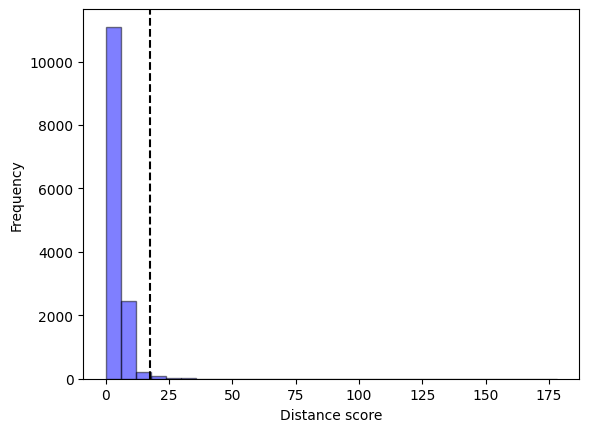

Threshold: 17.447361438435816
The anomalies percent for K-means is 1.0999281092739037%


In [112]:
km = KMeans()
km.fit(df_pca)
scores = km.transform(df_pca).min(axis=1)

plt.hist(scores, bins=30, color='b', alpha=0.5, edgecolor='black')

thresh = np.mean(scores) + 3 * np.std(scores)
plt.axvline(x=thresh, color='black', linestyle='--', linewidth=1.5)

plt.xlabel('Distance score')
plt.ylabel('Frequency')

plt.show()

print(f'Threshold: {thresh}')
print(f'The anomalies percent for K-means is {100 * len([i for i in scores if i > thresh]) / len(scores)}%')

Threshold: 387.43009917689324
The anomalies percent for one class SVM is 7.98705966930266%


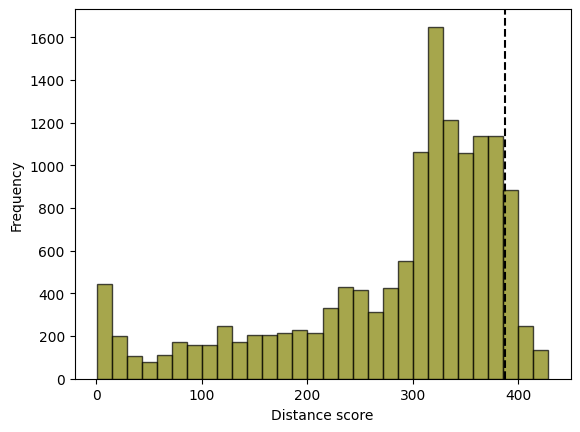

In [113]:
clf = OneClassSVM(gamma='auto')
clf.fit(df_pca)
scores = clf.score_samples(df_pca)

plt.hist(scores, bins=30, color='olive', alpha=0.7, edgecolor='black')

thresh = np.mean(scores) + 1 * np.std(scores)
plt.axvline(x=thresh, color='black', linestyle='--', linewidth=1.5)

print(f'Threshold: {thresh}')
print(f'The anomalies percent for one class SVM is {100 * len([i for i in scores if i > thresh]) / len(scores)}%')

plt.xlabel('Distance score')
plt.ylabel('Frequency')
plt.show()

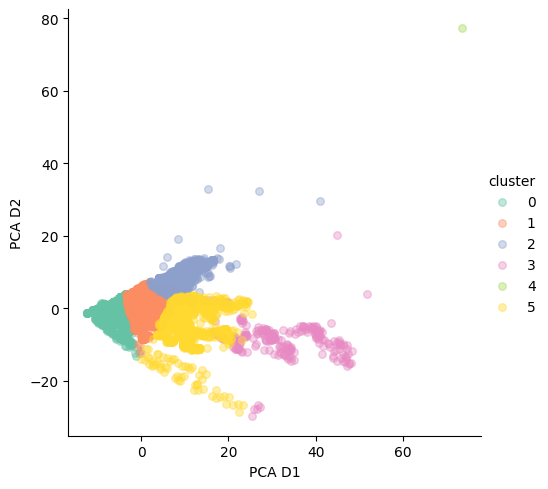

In [114]:
pca = PCA(n_components=2)           
reduced_features_df = pca.fit_transform(df_pca)
comp_x, comp_y = zip(*reduced_features_df)
df_pca['x'] = comp_x
df_pca['y'] = comp_y
df_pca['cluster'] = kmeans.labels_
sns.lmplot(data=df_pca, x='x', y='y', hue='cluster', fit_reg=False, height=5, palette='Set2', scatter_kws={'alpha':0.4, 's':30})
plt.xlabel("PCA D1")
plt.ylabel("PCA D2")
plt.show()